In [1]:
import sys
import subprocess
print(f"Python version: {sys.version}")
print(f"Platform: {sys.platform}")
assert sys.version_info >= (3, 10), "This notebook requires Python 3.10 or higher"

packages = ['torch', 'numpy', 'matplotlib', 'pillow', 'scikit-learn', 'pandas']
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
        print(f"✓ {package} installed")
    except Exception as e:
        print(f"✗ {package} failed: {e}")

print("Setup complete!")

Python version: 3.10.19 (main, Oct  9 2025, 15:25:03) [Clang 17.0.0 (clang-1700.3.19.1)]
Platform: darwin
✓ torch installed
✓ numpy installed
✓ matplotlib installed
✓ pillow installed
✓ scikit-learn installed
✓ pandas installed
Setup complete!


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(np.int64)

x_train = X[:60000].reshape(-1, 28, 28)
y_train = y[:60000]
x_test = X[60000:].reshape(-1, 28, 28)
y_test = y[60000:]

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

PyTorch version: 2.9.1
MPS available: True
Loading MNIST from OpenML...
MNIST loaded successfully
x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as f

class CNN(nn.Module):
  def __init__(self, output_size):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    
    self.pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.3)
    
    self.fc1 = nn.Linear(128 * 3 * 3, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, output_size)
    
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)

  def forward(self, x):
    if len(x.shape) == 3:
        x = x.unsqueeze(1)
    
    x = f.relu(self.bn1(self.conv1(x)))
    x = self.pool(x)
    x = self.dropout(x)
    
    x = f.relu(self.bn2(self.conv2(x)))
    x = self.pool(x)
    x = self.dropout(x)
    
    x = f.relu(self.bn3(self.conv3(x)))
    x = self.pool(x)
    x = self.dropout(x)
    
    x = x.view(x.size(0), -1)
    
    x = f.relu(self.fc1(x))
    x = self.dropout(x)
    x = f.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    
    return x

In [5]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self, images,labels):
    self.images = images
    self.labels = labels
  def __len__(self):
    return len(self.images)
  def __getitem__(self,idx):
    image = self.images[idx]
    label = self.labels[idx]
    return image,label

In [6]:
train_data = DataLoader(dataset(x_train,y_train),batch_size=64,shuffle=True)
test_data = DataLoader(dataset(x_test,y_test), batch_size=32, shuffle=False)

In [7]:
batch_size = 64
num_epochs = 5
learning_rate = 0.001
input_size = 28*28
output_size = 10

In [8]:
model = CNN(output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  for images, labels in train_data:
    images = images.float()
    labels = labels.long()
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  
  epoch_loss = running_loss / len(train_data)
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/5, Loss: 0.2633
Epoch 2/5, Loss: 0.0979
Epoch 3/5, Loss: 0.0781
Epoch 4/5, Loss: 0.0698
Epoch 5/5, Loss: 0.0607


In [10]:
model.eval()
correct = 0
total = 0

for images, labels in test_data:
   images = images.float()
   labels = labels.long()
   output = model(images)
   correct += (output.argmax(1) == labels).sum().item()
   total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.21%


 File  Expected  Predicted Confidence Correct
0.jpg         0          0     99.99%       ✓
1.jpg         1          1     93.61%       ✓
2.jpg         2          2    100.00%       ✓
3.jpg         3          3    100.00%       ✓
4.jpg         4          4    100.00%       ✓
5.jpg         5          5    100.00%       ✓
6.jpg         6          6     92.94%       ✓
7.jpg         7          7     92.21%       ✓
8.jpg         8          8     94.55%       ✓
9.jpg         9          9     97.59%       ✓

Accuracy: 10/10


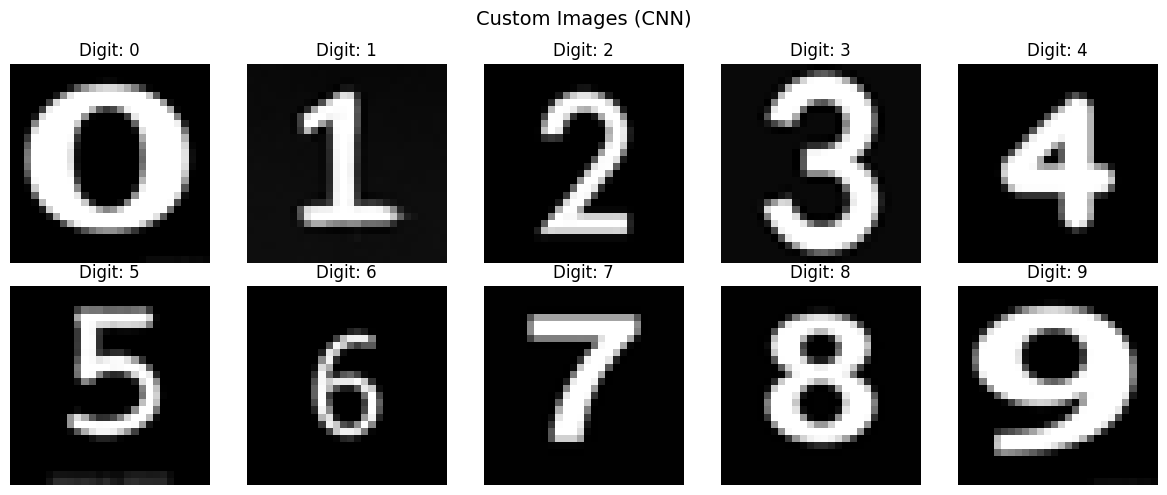

In [11]:
from PIL import Image
import os

results = []
processed_images = []

for digit in range(0, 10):
    img_path = f'/Users/purna/Downloads/{digit}.jpg'
    
    if os.path.isfile(img_path):
        img = Image.open(img_path).convert('L')
        img = img.resize((28, 28))
        img_array = np.array(img).astype(np.float32)
        
        if img_array.mean() > 127:
            img_array = 255 - img_array
        
        img_array = img_array / 255.0
        
        processed_images.append((digit, img_array))
        
        img_tensor = torch.from_numpy(img_array).unsqueeze(0).float()
        
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            prediction = output.argmax(1).item()
            confidence = torch.softmax(output, dim=1)[0][prediction].item() * 100
        
        results.append({
            'File': f'{digit}.jpg',
            'Expected': digit,
            'Predicted': prediction,
            'Confidence': f'{confidence:.2f}%',
            'Correct': '✓' if prediction == digit else '✗'
        })
    else:
        results.append({
            'File': f'{digit}.jpg',
            'Expected': digit,
            'Predicted': 'N/A',
            'Confidence': 'N/A',
            'Correct': 'File not found'
        })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print(f"\nAccuracy: {sum(1 for r in results if r['Correct'] == '✓')}/10")

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, (digit, img) in enumerate(processed_images[:10]):
    ax = axes[i // 5, i % 5]
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Digit: {digit}')
    ax.axis('off')
plt.suptitle('Custom Images (CNN)', fontsize=14)
plt.tight_layout()
plt.show()